# A Discrete Inquiry Into MCMC
This notebook explores the behavior of Markov chain Monte Carlo
on a discrete, finite-dimensional state space. We are given a positive function $q$
on the the set $S = \{ 0, 1, ..., d-1 \}$ and seek a Markov chain $P'$ on $S$ whose stationary 
distribution is $q$. 

The code below chooses $q$ from a small menu using Target_selector. We find $P'$ by first constructing a Markov chain $P$ on $S$ and then modifying $P$ into a suitable $P'$. The class P_selector contains a menu from which one chooses the first row of $P$, which specifies the transition probabilities from state 0 to other states. The method make_P_matrix then fills out the matrix $P$ by shifting the first row to create the other rows.

With $q$ and $P$ in hand, the function P_mcmc applies the MCMC algorithm to create P' = P_mcmc.

In [1]:
import numpy as np
dim = 9

In [4]:
class Target_selector:
    def __init__(self,dim):
        self.dim = dim
        
    def geometric(self):
        return 2**np.arange(dim)
    
    def factorial(self):
        q = np.array([])
        for number in range(1,self.dim+1):
            q = np.append(q,self.fact(number))
        return q
            
    def fact(self,n):
        if n > 1:
            return n * self.fact(n-1)
        else:
            return 1
        

### Choose a target distribution $q$ by choosing Target_selector's method. 

The menu provided here has only increasing functions $q$, to make the interpretation of the MCMC results easier. This is no restriction, as we can always relabel states to make $q$ increasing.

In [14]:
t = Target_selector(dim)
q = t.geometric()
q_dist = q/np.sum(q)  # normalize q for investigating convergence
print('Target distribution q: \n',np.round(q_dist,3))

Target distribution q: 
 [0.002 0.004 0.008 0.016 0.031 0.063 0.125 0.25  0.501]


In [2]:
# https://jaxenter.com/implement-switch-case-statement-python-138315.html
class P_selector:
    def __init__(self, dim, right):
        self.dim = dim
        self.right_jump = right
        
    def make_P_matrix(self,argument):
        row = self.first_row(argument)
        m = row
        for r in range(1,row.shape[1]):
            m = np.concatenate((m,
                                np.roll(row,r)),
                                axis=0)
        return m
        
    def first_row(self, argument):
        """Dispatch method"""
        method_name = str(argument)
        # Get the method from 'self'. Default to a lambda.
        method = getattr(self, method_name, lambda: "Invalid distribution")
        # Call the method as we return it
        return method()
    
#   Clock tick walk on the circle: one step clockwise per epoch
    def clock_tick(self):
        row = np.zeros((1,self.dim))
        row[0,1]=1
        return row
    
#   Markov chain with independent trials, uniform
    def uniform(self):
        return np.full((1,self.dim),1.0/self.dim)
    
#   Jump from state 0 to other states with equal probability
    def uniform_jump(self):
        row = np.full((1,self.dim),1.0/(self.dim-1))
        row[0,0] = 0
        return row
    
#   Adjacent neighbor random walk on the circle
    def random_walk(self):
        row = np.zeros((1,self.dim))
        row[0,1] = self.right_jump
        row[0,-1] = 1 - self.right_jump
        return row


### Choose the base Markov chain by choosing the argument of P_selector.make_P_matrix.

In [25]:
s  = P_selector(dim, 0.5)
P = s.make_P_matrix('uniform')
print('P:\n', np.round(P,2))
print (P.shape)

P:
 [[0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11]
 [0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11]
 [0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11]
 [0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11]
 [0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11]
 [0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11]
 [0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11]
 [0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11]
 [0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11]]
(9, 9)


The formula for the MCMC transition matrix $P_{mcmc} = P'$ is
\begin{equation*}
p'_{xy} = p_{xy} \min (1,{q_y p_{yx}}/{q_x p_{xy}} ) = \frac {\min (q_x p_{xy},q_y p_{yx})}{q_x}
\end{equation*}

### The next cell computes and displays P_mcmc. 

Note how the matrix entries above the diagonal are the same as those of $P$ because we do not decrease $p_{xy}$ when the flux from $x$ to $y$ is smaller than the flux from $y$ to $x$. However, below the diagonal, we do decrease $p_{xy}$ to lower the flux from $x$ to $y$, thereby making the Markov chain visit lower-numbered states less often in favor of revisiting the state on the diagonal. 

In [26]:
def P_mcmc(P,q):
    A = np.matmul(np.diag(q),P)
    C = np.minimum(A, A.T)  # the numerator of P'
    D = np.matmul(np.diag(1/q),C)
    return  D + np.diag(1.0 - np.sum(D,axis=1))
    
P_mcmc = P_mcmc(P,q)
print('P_mcmc:\n',np.round(P_mcmc,2))

P_mcmc:
 [[0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11]
 [0.06 0.17 0.11 0.11 0.11 0.11 0.11 0.11 0.11]
 [0.03 0.06 0.25 0.11 0.11 0.11 0.11 0.11 0.11]
 [0.01 0.03 0.06 0.35 0.11 0.11 0.11 0.11 0.11]
 [0.01 0.01 0.03 0.06 0.45 0.11 0.11 0.11 0.11]
 [0.   0.01 0.01 0.03 0.06 0.56 0.11 0.11 0.11]
 [0.   0.   0.01 0.01 0.03 0.06 0.67 0.11 0.11]
 [0.   0.   0.   0.01 0.01 0.03 0.06 0.78 0.11]
 [0.   0.   0.   0.   0.01 0.01 0.03 0.06 0.89]]


## Properties of P_mcmc
The next few cells verify that the MCMC algorithm behaves as predicted and explore some of the algorithm's properties.

First, we verify that q is the stationary distribution by qP_mcmc - q = 0

In [16]:
diff = np.dot(q,P_mcmc)-q
print('||qP_mcmc - q|| = ',np.sqrt(np.dot(diff,diff)))
print('Stationary distribution')

print(np.round(q_dist,3))

||qP_mcmc - q|| =  0.0
Stationary distribution
[0.002 0.004 0.008 0.016 0.031 0.063 0.125 0.25  0.501]


### How quickly does MCMC converge?

A standard result from Markov chains is that each row of the matrix power $(P')^n$ should converge to the stationary distribution $q$. The cell below finds the difference between the stationary distribution and each row of  $(P')^n$. Row $x$ is the distribution of the chain after $n$ steps, starting in state $x$.

The cell then calculates the largest difference, which represents the largest error over all initial states.  It uses two notions of difference, the total variation distance between a row of $(P')^n$ and $q$ and the Kullback-Leibler divergence. The square root of the KL divergence is known to bound the total variation distance.


P_mcmc ** 40 
 [[0.002 0.004 0.008 0.016 0.031 0.063 0.125 0.251 0.501]
 [0.002 0.004 0.008 0.016 0.031 0.063 0.125 0.251 0.501]
 [0.002 0.004 0.008 0.016 0.031 0.063 0.125 0.251 0.501]
 [0.002 0.004 0.008 0.016 0.031 0.063 0.125 0.251 0.501]
 [0.002 0.004 0.008 0.016 0.031 0.063 0.125 0.251 0.501]
 [0.002 0.004 0.008 0.016 0.031 0.063 0.125 0.251 0.501]
 [0.002 0.004 0.008 0.016 0.031 0.063 0.125 0.251 0.501]
 [0.002 0.004 0.008 0.016 0.031 0.063 0.125 0.251 0.501]
 [0.002 0.004 0.008 0.016 0.031 0.063 0.125 0.25  0.501]]


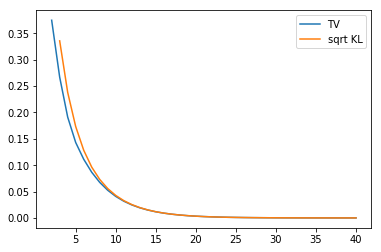

In [37]:

import matplotlib.pyplot as plt

def convergence_rate(P,max_power,stat_dist):
    M = P
    tv_array = np.array([])
    kl_array = np.array([])
    for p in range(1, max_power):
        M = np.matmul(M,P)
        tv = 0.5 * np.max(np.sum(np.fabs(M-stat_dist),axis=1))
        kl = 0.5 * np.max(np.sum(M*np.nan_to_num(np.log(M/stat_dist)),axis=1))        
        tv_array = np.append(tv_array, tv)
        kl_array = np.append(kl_array, np.nan_to_num(kl))
       
#         print(p+1,'\t', np.round(tv,5),'\t', np.round(np.sqrt(kl),5))
    print('\nP_mcmc **', max_power, '\n',np.round(M,3))
    return(tv_array,np.sqrt(kl_array))

# print('Power\t', 'Tot var\t','sqrt KL')
iterations = 40
TV, KL = convergence_rate(P_mcmc,iterations,q_dist)
#print (TV, KL)

plt.figure()
plt.plot(np.arange(2,2+TV.shape[0]),TV, label='TV')
plt.plot(np.arange(3,2+TV.shape[0]),KL[1:],label="sqrt KL")
plt.legend(loc='best')


### Eigenvalues of P_mcmc

Another well-known result about Markov chains (see https://en.wikipedia.org/wiki/Markov_chain#Steady-state_analysis_and_limiting_distributions ) is that the second largest eigenvalue of P_mcmc governs how quickly $(P')^n$ converges to a matrix all of whose rows are $q$.  The next cell calculates the rate.

In [36]:
#eigenvalues and eigenvectors of P_mcmc
from numpy import linalg as LA
e_values,e_vectors = LA.eig(P_mcmc.T)  # transpose to get left eigenvectors
print ('Eigenvalues of P_mcmc: ', np.round(e_values,2))

print('Geometric convergence rate (ratio of 2nd largest to largest eigenvalue) =', 
     np.round(np.sort(e_values)[-2]/np.sort(e_values)[-1],2))

Rank of P_mcmc =  9
Eigenvalues of P_mcmc:  [1.   0.78 0.67 0.06 0.56 0.14 0.45 0.24 0.34]
Geometric convergence rate (ratio of 2nd largest to largest eigenvalue) = 0.78


### Sample paths of P_mcmc

MCMC generates samples from the distribution $q$ by running the Markov chain P_mcmc and reading off the sequence of states the chain passes through (aka the sample path). By setting the parameter "epochs" below, you can generate a sample path of a desired length. 

You can see from the sample plot that the successive samples are not independent, even if we start with the base Markov chain "uniform" in which the state transition does not depend on the current state. The reason is that we increase the number of visits to states $x$ with high values of $q(x)$ by making the chain return to $x$ repeatedly. Such states have high values on the diagonal of P_mcmc.

Frequencies:  [0.002 0.007 0.016 0.016 0.061 0.062 0.122 0.245 0.47 ]


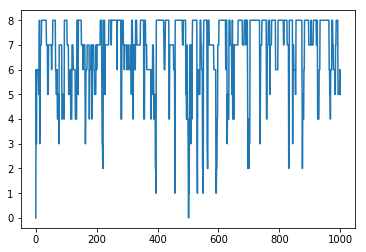

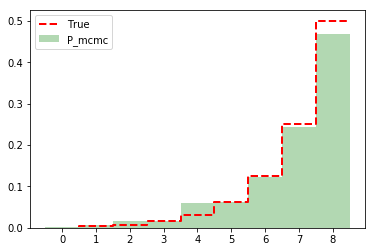

Stationary distribution:  [0.002 0.004 0.008 0.016 0.031 0.063 0.125 0.25  0.501]
MCMC Density:  [0.002 0.007 0.016 0.016 0.061 0.062 0.122 0.245 0.47 ]


In [33]:
import matplotlib.pyplot as plt

def transition(state, cum_matrix, rnd):
    return np.argmax(cum_matrix[state,:] > rnd)

def generate_path(tr_matrix, init_state, unif):
    C = np.cumsum(tr_matrix,axis=1)
    #print(np.round(C,2))
    path = np.array(init_state)
    state = init_state
    for u in unif:
        state = transition(state,C,u)
        path = np.append(path,state)
    return path

def plot_density(path,label1,x,st_dist,label2):
    plt.figure()
    #counts,bins,patches = plt.hist(path,bins=dim,facecolor='green', alpha=0.5,label=label)
    counts,bins,patches = plt.hist(path,
                                   np.arange(min(path)-0.5, max(path)+1.0+0.5),
                                   density=True,
                                   facecolor='green', 
                                   #histtype='step',
                                   alpha=0.3,
                                   label=label1)
    plt.xticks(range(min(path), 1+max(path)))
    plt.step(x+0.5,st_dist,
             linewidth=2, 
             linestyle='dashed',
             color='r',
             label=label2)
    #print('bins: ',bins)
    print('Frequencies: ',np.round(counts,3))
    #print('Ratios: ',np.round(counts[1:]/counts[:-1],3))
    plt.legend(loc='best')
    plt.grid(False)
    plt.show()
    return counts/np.sum(counts)

# Generate a Markov chain sample path
epochs = 1000
rng = np.random.RandomState(10)
uniform = rng.random_sample(epochs)
#print(uniform.shape)

initial_state = 0
path = generate_path(P_mcmc,initial_state,uniform)
plt.plot(path)

x = np.arange(0,dim,1)
density = plot_density(path,'P_mcmc',x,q_dist,'True')
print('Stationary distribution: ',np.round(v0,3))
print('MCMC Density: ',np.round(density,3))


### Correlation
Successive samples from P_mcmc are correlated. How much?

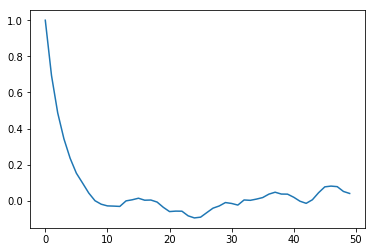

In [34]:
from scipy.ndimage.interpolation import shift
def cov_function(X,max_lag):
    X = X - np.mean(X)
    cov_fn = np.array([])
    for lag in range(max_lag):
        cov_fn = np.append(cov_fn,np.dot(X,shift(X,lag,cval=0)))
    return cov_fn/(X.shape[0] - 1)

max_lag = 50
covs = cov_function(path,max_lag)
plt.plot(np.arange(0,covs.shape[0]),covs/covs[0])

### Recurrence times

A Markov chain's stationary distribution at a given state is inversely proportional to the mean time between returns to that state (the mean recurrence time). This cell compares the two on the sample path created above.

In [35]:
# recurrence times
def mean_recurrence(path):
    mr = np.array([])
    states = np.unique(path)
    for s in states:
        v = np.where(path==s)[0]  # where returns a tuple, even if 1-dimensional
        mr = np.append(mr,np.mean(v[1:] - v[:-1]))
    return mr

rec = mean_recurrence(path)
rec = 1.0/rec
print('Stationary distribution: ',np.round(v0,3))
print('Mean recurrence times: ',np.round(rec,3))

Stationary distribution:  [0.002 0.004 0.008 0.016 0.031 0.063 0.125 0.25  0.501]
Mean recurrence times:  [0.002 0.03  0.023 0.018 0.063 0.061 0.121 0.251 0.479]
